In [157]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import sys 
sys.path.append('../ELMo')
from ELMO_used import ELMo
import wandb
import re
import pandas as pd 
from preprocessing import tokenize, CharLevelVocab, WordLevelVocab

In [158]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [159]:
char_vocab = torch.load('./Hindi_ELMo/character_vocab_hindi.pt')
word_vocab = torch.load('./Hindi_ELMo/vocab_hindi.pt')

In [160]:
elmo = ELMo(cnn_config = {'character_embedding_size': 16, 
                           'num_filters': 32, 
                           'kernel_size': 5, 
                           'max_word_length': 10, 
                           'char_vocab_size': char_vocab.num_chars}, 
             elmo_config = {'num_layers': 3,
                            'word_embedding_dim': 150,
                            'vocab_size': word_vocab.num_words}, 
             char_vocab_size = char_vocab.num_chars).to(device)

In [161]:
elmo.load_state_dict(torch.load('./Hindi_ELMo/model_elmo_hindi.pt'))

<All keys matched successfully>

In [162]:
train_df = pd.read_parquet('train-00000-of-00001.parquet')
test_df = pd.read_parquet('test-00000-of-00001.parquet')
val_df = pd.read_parquet('validation-00000-of-00001.parquet')

In [163]:
train_df

,hypothesis,premise,label
0,मैंने गाजर के माध्यम से एक पिन चिपका दिया। जब ...,गाजर में छेद था।,1
1,जॉन उसके सामने बिली के साथ मंच नहीं देख सका क्...,जॉन इतना छोटा है।,1
2,पुलिस ने गिरोह के सभी सदस्यों को गिरफ्तार कर ल...,पुलिस पड़ोस में नशे के कारोबार को रोकने की कोश...,1
3,स्टीव सब कुछ में फ्रेड के उदाहरण का अनुसरण करत...,स्टीव उसे बेहद प्रभावित करता है।,1
4,"जब तात्याना केबिन में पहुंची, तो उसकी मां सो र...","माँ सावधान थी कि उसे परेशान न करें, नंगा करके ...",1
...,...,...,...
630,"जब टॉमी ने अपनी आइसक्रीम को गिरा दिया, तो टिम्...",पिता ने टिम्मी को एक सहानुभूतिपूर्ण रूप दिया।,1
631,"मार्क ने पीट को अपने बारे में कई झूठ बताए, जिस...",पीट को और अधिक संदेह होना चाहिए था।,1
632,"टॉम ने राल्फ को ""चेक"" कहा क्योंकि उसने अपना बि...","टॉम ने राल्फ को ""चेक"" कहा क्योंकि उसने टॉम का ...",1
633,"एम्मा की मां की मृत्यु बहुत पहले हो गई थी, और ...",एम्मा की माँ का स्थान एक उत्कृष्ट महिला द्वारा...,1


In [164]:
# print unique values of the label column
print(train_df['label'].unique())

[1]


In [165]:
print(test_df['label'].unique(), val_df['label'].unique())

[2] [1]


In [166]:
# combine train and val df into a 1_df 
df_1 = pd.concat([train_df, val_df])
df_2 = test_df

In [167]:
df_1

,hypothesis,premise,label
0,मैंने गाजर के माध्यम से एक पिन चिपका दिया। जब ...,गाजर में छेद था।,1
1,जॉन उसके सामने बिली के साथ मंच नहीं देख सका क्...,जॉन इतना छोटा है।,1
2,पुलिस ने गिरोह के सभी सदस्यों को गिरफ्तार कर ल...,पुलिस पड़ोस में नशे के कारोबार को रोकने की कोश...,1
3,स्टीव सब कुछ में फ्रेड के उदाहरण का अनुसरण करत...,स्टीव उसे बेहद प्रभावित करता है।,1
4,"जब तात्याना केबिन में पहुंची, तो उसकी मां सो र...","माँ सावधान थी कि उसे परेशान न करें, नंगा करके ...",1
...,...,...,...
66,मैंने बोतल से बोतल में तब तक पानी डाला जब तक व...,बोतल खाली थी।,1
67,एलिस ने भीड़ में अपने दोस्त जेड की तलाश की। चू...,"चूंकि ऐलिस हमेशा एक लाल पगड़ी पहनती है, इसलिए ...",1
68,"कुत्ते ने बिल्ली का पीछा किया, जो एक पेड़ के ऊ...",बिल्ली शीर्ष पर इंतजार कर रही थी।,1
69,"गर्मियों की दोपहर थी, और कुत्ता लॉन के बीच में...",पेड़ के नीचे का स्थान गर्म था।,1


In [168]:
df_2

,hypothesis,premise,label
0,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,जब मौड और डोरा नजर आए तो घोड़े भाग गए।,2
1,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,गाड़ियों के आते ही घोड़े भाग गए।,2
2,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,कश नजर आने पर घोड़े भाग गए।,2
3,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,घोड़ों की नजर पड़ते ही घोड़े भाग गए।,2
4,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,सीटी देखते ही घोड़े दौड़े।,2
...,...,...,...
141,मुरील ने अपने लिविंग रूम में सेसिल डी'ब्रले की...,यह म्यूरियल के बाद के काम की बहुत विशेषता है -...,2
142,मुरील ने अपने लिविंग रूम में सेसिल डी'ब्रले की...,यह थेरेसा रूबियो के बाद के काम की बहुत विशेषता...,2
143,मुरील ने अपने लिविंग रूम में सेसिल डी'ब्रले की...,यह वास्तविक समय के बजाय सेसिल डी'ब्रले के बाद ...,2
144,एडवर्ड ने अपनी खिड़की दासा पर चिपकने वाला टेप ...,कुछ गोंद टेप पर अटक गया था।,2


In [169]:
hypotheses = df_1[:280]['hypothesis'].tolist()
premises = df_1[:280]['premise'].tolist()

In [170]:
# shift hypothesis by 2
extra_1 = hypotheses[0:2]
hypotheses = hypotheses[2:]
hypotheses.extend(extra_1)

# hypotheses

In [171]:
# make a df_neg with columns same as df_1 

df_neg = pd.DataFrame(columns = df_1.columns)

# populate it with the shifted hypotheses and premises
df_neg['hypothesis'] = hypotheses
df_neg['premise'] = premises

# add the label column with all 0s
df_neg['label'] = 0

df_neg

,hypothesis,premise,label
0,पुलिस ने गिरोह के सभी सदस्यों को गिरफ्तार कर ल...,गाजर में छेद था।,0
1,स्टीव सब कुछ में फ्रेड के उदाहरण का अनुसरण करत...,जॉन इतना छोटा है।,0
2,"जब तात्याना केबिन में पहुंची, तो उसकी मां सो र...",पुलिस पड़ोस में नशे के कारोबार को रोकने की कोश...,0
3,"जॉर्ज को नाटक के लिए मुफ्त टिकट मिले, लेकिन उन...",स्टीव उसे बेहद प्रभावित करता है।,0
4,जॉन पार्क के माध्यम से जॉगिंग कर रहा था जब उसन...,"माँ सावधान थी कि उसे परेशान न करें, नंगा करके ...",0
...,...,...,...
275,डैन को घायल पक्षी के साथ बिल को मरने से रोकना ...,लिली की चुप्पी को तोड़ते हुए लिली ने डोना से ब...,0
276,ऐन ने मैरी से पूछा कि लाइब्रेरी किस समय बंद हो...,बॉब हार जाएगा।,0
277,मूर्तिकला शेल्फ से लुढ़क गई क्योंकि यह लंगर नह...,दान बहुत क्रूर है।,0
278,मैंने गाजर के माध्यम से एक पिन चिपका दिया। जब ...,मैरी भूल गई थी।,0


In [172]:
# change the label column in df_2 to 0
df_2['label'] = 0

# combine df_2 and df_neg
df_neg = pd.concat([df_2, df_neg])

df_neg

,hypothesis,premise,label
0,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,जब मौड और डोरा नजर आए तो घोड़े भाग गए।,0
1,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,गाड़ियों के आते ही घोड़े भाग गए।,0
2,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,कश नजर आने पर घोड़े भाग गए।,0
3,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,घोड़ों की नजर पड़ते ही घोड़े भाग गए।,0
4,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,सीटी देखते ही घोड़े दौड़े।,0
...,...,...,...
275,डैन को घायल पक्षी के साथ बिल को मरने से रोकना ...,लिली की चुप्पी को तोड़ते हुए लिली ने डोना से ब...,0
276,ऐन ने मैरी से पूछा कि लाइब्रेरी किस समय बंद हो...,बॉब हार जाएगा।,0
277,मूर्तिकला शेल्फ से लुढ़क गई क्योंकि यह लंगर नह...,दान बहुत क्रूर है।,0
278,मैंने गाजर के माध्यम से एक पिन चिपका दिया। जब ...,मैरी भूल गई थी।,0


In [173]:
df_pos = df_1[280:]
df_pos

,hypothesis,premise,label
280,कैरोल ने माना कि रेबेका को संदेह था कि उसने घड...,कैरोल ने माना कि रेबेका को संदेह था कि कैरोल न...,1
281,"पॉल ने फोन पर जॉर्ज को फोन करने की कोशिश की, ल...",जॉर्ज सफल नहीं था।,1
282,"मैरी ने अपनी बेटी ऐनी को बिस्तर पर लिटा दिया, ...","मैरी ने अपनी बेटी ऐनी को बिस्तर पर लिटा दिया, ...",1
283,जेम्स ने रॉबर्ट से एक एहसान माँगा लेकिन उसने म...,रॉबर्ट ने मना कर दिया।,1
284,"मुझे एक चम्मच नहीं मिला, इसलिए मैंने अपनी कॉफी...",कॉफ़ी में कॉफी भर गई।,1
...,...,...,...
66,मैंने बोतल से बोतल में तब तक पानी डाला जब तक व...,बोतल खाली थी।,1
67,एलिस ने भीड़ में अपने दोस्त जेड की तलाश की। चू...,"चूंकि ऐलिस हमेशा एक लाल पगड़ी पहनती है, इसलिए ...",1
68,"कुत्ते ने बिल्ली का पीछा किया, जो एक पेड़ के ऊ...",बिल्ली शीर्ष पर इंतजार कर रही थी।,1
69,"गर्मियों की दोपहर थी, और कुत्ता लॉन के बीच में...",पेड़ के नीचे का स्थान गर्म था।,1


In [174]:
# make train_neg out of 80% of df_neg
train_neg = df_neg[:int(0.8*len(df_neg))]
# make val neg out of 10% of df_neg
val_neg = df_neg[int(0.8*len(df_neg)):int(0.9*len(df_neg))]
# make test neg out of 10% of df_neg
test_neg = df_neg[int(0.9*len(df_neg)):]

# make train_pos out of 80% of df_pos
train_pos = df_pos[:int(0.8*len(df_pos))]
# make val pos out of 10% of df_pos
val_pos = df_pos[int(0.8*len(df_pos)):int(0.9*len(df_pos))]
# make test pos out of 10% of df_pos
test_pos = df_pos[int(0.9*len(df_pos)):]

In [175]:
# combine train_pos and train_neg
train_df = pd.concat([train_pos, train_neg])
# shuffle
train_df = train_df.sample(frac=1).reset_index(drop=True)

# combine val_pos and val_neg
val_df = pd.concat([val_pos, val_neg])

# combine test_pos and test_neg
test_df = pd.concat([test_pos, test_neg])

In [176]:
train_df

,hypothesis,premise,label
0,मौड और डोरा ने गाड़ियों को प्राइरी के पार भागत...,सीटियों ने एक ट्रेन को आते देखा।,0
1,जोआन ने सुसान को उसकी मदद के लिए धन्यवाद देना ...,जोआन ने सुसान को फिर से मदद देने के लिए सुसान ...,1
2,आखिरी दिन आ गया। कल नेल दूर जा रहा था। पापा और...,डैड और मॉम घर में नेल की नई डिक्की लेकर आए थे।,0
3,ग्रांट ने अपनी फलियों को काटने के लिए कड़ी मेह...,बड़ी गेंद स्टील से बनी थी।,0
4,मौड ने फिर सोचा कि बर्नार्ड उसे घर क्यों देख र...,उसने सोचा कि पिताजी को एक सुखद हंसी आई।,0
...,...,...,...
675,"आपका जीवन आपका और आपका अकेला है, और यदि दर्द ल...",आपके पास लाभ समाप्त करने का विकल्प होना चाहिए।,0
676,"उन्होंने एक घोषणा प्रसारित की, लेकिन एक सबवे स...",मैं घोषणा नहीं सुन सका।,1
677,दीवार में एक फासला है। आप इसके पीछे बगीचे को द...,आप गैप के माध्यम से बगीचे को देख सकते हैं।,1
678,पाम के माता-पिता घर आए और उसे अपने प्रेमी पॉल ...,इसे लेकर पाम के माता-पिता शर्मिंदा थे।,1


In [177]:
train_hypotheses = train_df['hypothesis'].tolist()
train_premises = train_df['premise'].tolist()
train_labels = train_df['label'].tolist()

val_hypotheses = val_df['hypothesis'].tolist()
val_premises = val_df['premise'].tolist()
val_labels = val_df['label'].tolist()

test_hypotheses = test_df['hypothesis'].tolist()
test_premises = test_df['premise'].tolist()
test_labels = test_df['label'].tolist()

In [178]:
train_premises

['सीटियों ने एक ट्रेन को आते देखा।',
 'जोआन ने सुसान को फिर से मदद देने के लिए सुसान का शुक्रिया अदा किया।',
 'डैड और मॉम घर में नेल की नई डिक्की लेकर आए थे।',
 'बड़ी गेंद स्टील से बनी थी।',
 'उसने सोचा कि पिताजी को एक सुखद हंसी आई।',
 'विरोधी अल्पमत में बहुत थे।',
 'बिली इतना छोटा है।',
 'बारिश 10 तक जारी रही।',
 'मार्क उसे समझ नहीं पाए।',
 'डॉ। एडम्स को कैंसर था और उन्होंने भविष्य के उपचार के लिए कई विकल्प प्रस्तुत किए।',
 'सैम की ड्राइंग इसके नीचे एक और एक के साथ बहुत बेहतर दिखती थी।',
 'लिली ने डोना से बात की, डोना की एकाग्रता को तोड़ते हुए।',
 'इतनी दूर से फायरमैन आ रहे थे।',
 "म्यूरियल ने अपने लिविंग रूम में सेसिल डी'ब्रब्ले के जूते पर बैलेरीना के सेसिल डी'ब्र्ले की प्रसिद्ध पेंटिंग लगाई है।",
 'मछली दो साल पहले शुरू हुई थी।',
 'उन्हें बसने वालों को नियमित करने के लिए नियम बनाने चाहिए।',
 'मेज टूट गई।',
 'इतनी दूर से पुलिस वाले आ रहे थे।',
 'सुसान निराश था।',
 'मार्क ने उन्हें कप्तान के लिए पुकारते हुए सुना',
 'मैंने अपने बैग को सूखा रखने के लिए अखबार को अपने बैग पर रख दिया।',
 '

In [179]:
train_premises_copy = train_premises.copy()
train_hypotheses_copy = train_hypotheses.copy()

val_premises_copy = val_premises.copy()
val_hypotheses_copy = val_hypotheses.copy()

test_premises_copy = test_premises.copy()
test_hypotheses_copy = test_hypotheses.copy()

In [180]:
def split_into_characters(tokenized_data, character_vocab, word_length, sen_len):

    sentences = []
    # convert sentences inot a list of list of characters
    for sentence in tokenized_data:
        sentence_chars = []
        for word in sentence:
            word_chars = []
            for char in word:
                word_chars.append(character_vocab.char_to_index(char))
            # pad the word to a fixed length
            if len(word_chars) < word_length:
                word_chars += [0] * (word_length - len(word_chars))
            if len(word_chars) > word_length:
                word_chars = word_chars[:word_length]
            sentence_chars.append(word_chars)
        if len(sentence_chars) < sen_len:
            sentence_chars += [[0] * word_length] * (sen_len - len(sentence_chars))
        if len(sentence_chars) > sen_len:
            sentence_chars = sentence_chars[:sen_len]

        sentences.append(sentence_chars)

    return sentences

In [181]:
class NLIDataset(Dataset):
    def __init__(self, hypotheses, premises, labels):
        self.hypotheses = tokenize(hypotheses)
        self.premises = tokenize(premises)
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.hypotheses[idx]), torch.tensor(self.premises[idx]), torch.tensor(self.labels[idx])
    
    def format(self, char_vocab):
        hypotheses = split_into_characters(self.hypotheses, char_vocab, 10, 15)
        premises = split_into_characters(self.premises, char_vocab, 10, 15)

        hypotheses = [[torch.tensor(word, dtype=torch.long) for word in sentence] for sentence in hypotheses]
        premises = [[torch.tensor(word, dtype=torch.long) for word in sentence] for sentence in premises]

        return hypotheses, premises, torch.tensor(self.labels, dtype=torch.long)

In [182]:
nli_train_dataset = NLIDataset(train_hypotheses, train_premises, train_labels)
train_hypotheses, train_premises, train_labels = nli_train_dataset.format(char_vocab)
print(type(train_hypotheses), type(train_premises), type(train_labels))

<class 'list'> <class 'list'> <class 'torch.Tensor'>


In [183]:
# chekc dataset
print(len(train_hypotheses), len(train_premises), len(train_labels))

680 680 680


In [184]:
def create_dataloader(s1, s2, scores, batch_size):
    zipped = list(zip(s1, s2, scores))
    dataloader = DataLoader(zipped, batch_size=batch_size, shuffle=True)
    return dataloader

In [185]:
train_dataloader = create_dataloader(train_hypotheses, train_premises, train_labels, 32)

In [186]:
nli_val_dataset = NLIDataset(val_hypotheses, val_premises, val_labels)
val_hypotheses, val_premises, val_labels = nli_val_dataset.format(char_vocab)

val_dataloader = create_dataloader(val_hypotheses, val_premises, val_labels, 32)

nli_test_dataset = NLIDataset(test_hypotheses, test_premises, test_labels)
test_hypotheses, test_premises, test_labels = nli_test_dataset.format(char_vocab)

test_dataloader = create_dataloader(test_hypotheses, test_premises, test_labels, 32)

In [187]:
for batch in train_dataloader:
    print(batch)
    break

[[tensor([[29, 15, 10,  9,  0,  0,  0,  0,  0,  0],
        [21, 22,  0,  0,  0,  0,  0,  0,  0,  0],
        [21, 22,  0,  0,  0,  0,  0,  0,  0,  0],
        [32, 16, 21,  8,  0,  0,  0,  0,  0,  0],
        [13, 25, 11,  8,  5,  0,  0,  0,  0,  0],
        [21, 24, 15,  2, 50,  0,  0,  0,  0,  0],
        [13,  5,  4,  7,  0,  0,  0,  0,  0,  0],
        [13,  2,  4,  6,  3,  0,  0,  0,  0,  0],
        [21,  4, 34,  4, 14, 13, 11, 20, 16, 11],
        [17,  2, 13,  0,  0,  0,  0,  0,  0,  0],
        [29, 13,  6, 13,  2,  0,  0,  0,  0,  0],
        [ 9, 10, 33,  0,  0,  0,  0,  0,  0,  0],
        [21, 10, 13,  0,  0,  0,  0,  0,  0,  0],
        [15, 59, 47, 52,  4,  0,  0,  0,  0,  0],
        [21, 22,  0,  0,  0,  0,  0,  0,  0,  0],
        [17,  2, 13,  0,  0,  0,  0,  0,  0,  0],
        [35, 39, 26, 33, 16,  4,  0,  0,  0,  0],
        [13, 25,  4,  7,  0,  0,  0,  0,  0,  0],
        [22, 59, 22,  0,  0,  0,  0,  0,  0,  0],
        [20, 24,  3,  2,  8, 20,  2,  4,  0,  0]

In [188]:
class NLIModel(nn.Module):
    def __init__(self, elmo, embedding_dim, hidden_dim_1, hidden_dim_2, num_classes, device):
        super(NLIModel, self).__init__()
        self.elmo = elmo
        self.lambdas = nn.Parameter(torch.randn(3))
        # self.fc1 = nn.Linear(embedding_dim, hidden_dim_1)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim_1, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim_1, num_classes)
        # self.fc2 = nn.Linear(hidden_dim_2, num_classes)
        self.non_linearity = nn.ReLU()

        for param in self.elmo.parameters():
            param.requires_grad = False

    def forward(self, s1, s2):
        _, _, final_embeddings_1 = self.elmo(s1)
        _, _, final_embeddings_2 = self.elmo(s2)

        encoding_1 = torch.zeros_like(final_embeddings_1[0])
        encoding_2 = torch.zeros_like(final_embeddings_2[0])

        for i in range(3):
            encoding_1 += self.lambdas[i] * final_embeddings_1[i]
            encoding_2 += self.lambdas[i] * final_embeddings_2[i]

        # concatenate encoding_1 and the encoding_2 
        encoding = torch.cat((encoding_1, torch.zeros_like(encoding_1)), dim=1)
        encoding = torch.cat((encoding, encoding_2), dim=1)

        output, _ = self.lstm(encoding)
        # output = self.fc1(encoding)
        # output = self.non_linearity(output)
        output = self.fc(output)
        output = self.non_linearity(output)
        # output = self.fc2(output)

        return output

In [189]:
nli_model = NLIModel(elmo, 300, 150, 75, 2, device).to(device)
num_epochs = 40
# set criterion as binary cross entropy
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nli_model.parameters(), lr=0.001)

In [190]:
import matplotlib.pyplot as plt
def train(model, num_epochs, criterion, optimizer):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total = 0 
        correct = 0

        for s1, s2, scores in tqdm(train_dataloader):
            s1 = s1
            s2 = s2
            scores = scores.to(device)
            optimizer.zero_grad()
            s1 = torch.stack(s1, dim=1).to(device)
            s2 = torch.stack(s2, dim=1).to(device)
            output = model(s1, s2)
            output = output[:,-1,:]
            # one hot encode the scores
            # scores = nn.functional.one_hot(scores, num_classes=2).float().to(device)
            # print(output.shape, scores.shape)
            pred = torch.argmax(output, dim=1)
            correct += (pred == scores).sum().item()
            total += scores.size(0)
            loss = criterion(output, scores)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss/len(train_dataloader))
        train_accuracies.append(correct/total)
        print(f'Epoch {epoch+1}/{num_epochs} Loss: {total_loss/len(train_dataloader)} Accuracy: {correct/total}')
    
    # validation 
        model.eval()
        correct = 0
        total = 0
        total_loss = 0
        with torch.no_grad():
            for s1, s2, scores in val_dataloader:
                s1 = s1
                s2 = s2

                s1 = torch.stack(s1, dim=1).to(device)
                s2 = torch.stack(s2, dim=1).to(device)
                scores = scores.to(device)
                output = model(s1, s2)
                output = output[:,-1,:]
                
                loss = criterion(output, scores)
                total_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += scores.size(0)
                correct += (predicted == scores).sum().item()

        val_losses.append(total_loss/len(val_dataloader))
        val_accuracies.append(correct/total)
        print(f'Validation Accuracy: {correct/total}')

    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'g', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_plot.png')
    plt.show()

100%|██████████| 22/22 [00:01<00:00, 12.49it/s]


Epoch 1/40 Loss: 0.6966806650161743 Accuracy: 0.5044117647058823
Validation Accuracy: 0.5


100%|██████████| 22/22 [00:01<00:00, 12.94it/s]


Epoch 2/40 Loss: 0.6909225664355538 Accuracy: 0.5147058823529411
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.96it/s]


Epoch 3/40 Loss: 0.6836655871434645 Accuracy: 0.5338235294117647
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.91it/s]


Epoch 4/40 Loss: 0.6659462479027835 Accuracy: 0.5367647058823529
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.90it/s]


Epoch 5/40 Loss: 0.6391610584475778 Accuracy: 0.5676470588235294
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.84it/s]


Epoch 6/40 Loss: 0.6307927613908594 Accuracy: 0.5661764705882353
Validation Accuracy: 0.46511627906976744


100%|██████████| 22/22 [00:01<00:00, 12.89it/s]


Epoch 7/40 Loss: 0.6024019582705065 Accuracy: 0.5911764705882353
Validation Accuracy: 0.5116279069767442


100%|██████████| 22/22 [00:01<00:00, 12.88it/s]


Epoch 8/40 Loss: 0.5935621017759497 Accuracy: 0.5794117647058824
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.81it/s]


Epoch 9/40 Loss: 0.5840222442691977 Accuracy: 0.5897058823529412
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.91it/s]


Epoch 10/40 Loss: 0.5631188641894947 Accuracy: 0.5955882352941176
Validation Accuracy: 0.5


100%|██████████| 22/22 [00:01<00:00, 12.86it/s]


Epoch 11/40 Loss: 0.5623008974573829 Accuracy: 0.5970588235294118
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.78it/s]


Epoch 12/40 Loss: 0.5535708069801331 Accuracy: 0.6029411764705882
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.83it/s]


Epoch 13/40 Loss: 0.5621612071990967 Accuracy: 0.611764705882353
Validation Accuracy: 0.5116279069767442


100%|██████████| 22/22 [00:01<00:00, 12.79it/s]


Epoch 14/40 Loss: 0.5345845127647574 Accuracy: 0.6294117647058823
Validation Accuracy: 0.5


100%|██████████| 22/22 [00:01<00:00, 12.74it/s]


Epoch 15/40 Loss: 0.5529146790504456 Accuracy: 0.5941176470588235
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.74it/s]


Epoch 16/40 Loss: 0.5337458103895187 Accuracy: 0.6235294117647059
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.64it/s]


Epoch 17/40 Loss: 0.5150918188420209 Accuracy: 0.638235294117647
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.64it/s]


Epoch 18/40 Loss: 0.4913839521733197 Accuracy: 0.6558823529411765
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.67it/s]


Epoch 19/40 Loss: 0.47409753095019946 Accuracy: 0.6779411764705883
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.65it/s]


Epoch 20/40 Loss: 0.48176694187251007 Accuracy: 0.6529411764705882
Validation Accuracy: 0.5


100%|██████████| 22/22 [00:01<00:00, 12.66it/s]


Epoch 21/40 Loss: 0.43505374816330994 Accuracy: 0.7044117647058824
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.66it/s]


Epoch 22/40 Loss: 0.4168879606507041 Accuracy: 0.7352941176470589
Validation Accuracy: 0.5348837209302325


100%|██████████| 22/22 [00:01<00:00, 12.64it/s]


Epoch 23/40 Loss: 0.5346238951791417 Accuracy: 0.6294117647058823
Validation Accuracy: 0.5116279069767442


100%|██████████| 22/22 [00:01<00:00, 12.65it/s]


Epoch 24/40 Loss: 0.5099314248019998 Accuracy: 0.6602941176470588
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.66it/s]


Epoch 25/40 Loss: 0.41353691572492773 Accuracy: 0.7411764705882353
Validation Accuracy: 0.5348837209302325


100%|██████████| 22/22 [00:01<00:00, 12.66it/s]


Epoch 26/40 Loss: 0.4147499352693558 Accuracy: 0.7338235294117647
Validation Accuracy: 0.46511627906976744


100%|██████████| 22/22 [00:01<00:00, 12.66it/s]


Epoch 27/40 Loss: 0.4079264903610403 Accuracy: 0.7323529411764705
Validation Accuracy: 0.4418604651162791


100%|██████████| 22/22 [00:01<00:00, 12.66it/s]


Epoch 28/40 Loss: 0.3698161799799312 Accuracy: 0.7647058823529411
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.66it/s]


Epoch 29/40 Loss: 0.37042262066494336 Accuracy: 0.7676470588235295
Validation Accuracy: 0.47674418604651164


100%|██████████| 22/22 [00:01<00:00, 12.65it/s]


Epoch 30/40 Loss: 0.34781094979156146 Accuracy: 0.8
Validation Accuracy: 0.46511627906976744


100%|██████████| 22/22 [00:01<00:00, 12.53it/s]


Epoch 31/40 Loss: 0.31917583603750577 Accuracy: 0.8147058823529412
Validation Accuracy: 0.45348837209302323


100%|██████████| 22/22 [00:01<00:00, 12.55it/s]


Epoch 32/40 Loss: 0.2879028916358948 Accuracy: 0.8647058823529412
Validation Accuracy: 0.4418604651162791


100%|██████████| 22/22 [00:01<00:00, 12.53it/s]


Epoch 33/40 Loss: 0.26230997524478217 Accuracy: 0.8720588235294118
Validation Accuracy: 0.4418604651162791


100%|██████████| 22/22 [00:01<00:00, 12.54it/s]


Epoch 34/40 Loss: 0.2555197050625628 Accuracy: 0.8867647058823529
Validation Accuracy: 0.43023255813953487


100%|██████████| 22/22 [00:01<00:00, 12.53it/s]


Epoch 35/40 Loss: 0.24698421020399441 Accuracy: 0.8897058823529411
Validation Accuracy: 0.4069767441860465


100%|██████████| 22/22 [00:01<00:00, 12.52it/s]


Epoch 36/40 Loss: 0.21051085029136052 Accuracy: 0.8970588235294118
Validation Accuracy: 0.43023255813953487


100%|██████████| 22/22 [00:01<00:00, 12.51it/s]


Epoch 37/40 Loss: 0.19372386756268414 Accuracy: 0.9147058823529411
Validation Accuracy: 0.4186046511627907


100%|██████████| 22/22 [00:01<00:00, 12.53it/s]


Epoch 38/40 Loss: 0.18737067079002206 Accuracy: 0.9161764705882353
Validation Accuracy: 0.46511627906976744


100%|██████████| 22/22 [00:01<00:00, 12.52it/s]


Epoch 39/40 Loss: 0.14858373152938756 Accuracy: 0.9279411764705883
Validation Accuracy: 0.4883720930232558


100%|██████████| 22/22 [00:01<00:00, 12.53it/s]


Epoch 40/40 Loss: 0.17006215774877506 Accuracy: 0.9235294117647059
Validation Accuracy: 0.4883720930232558


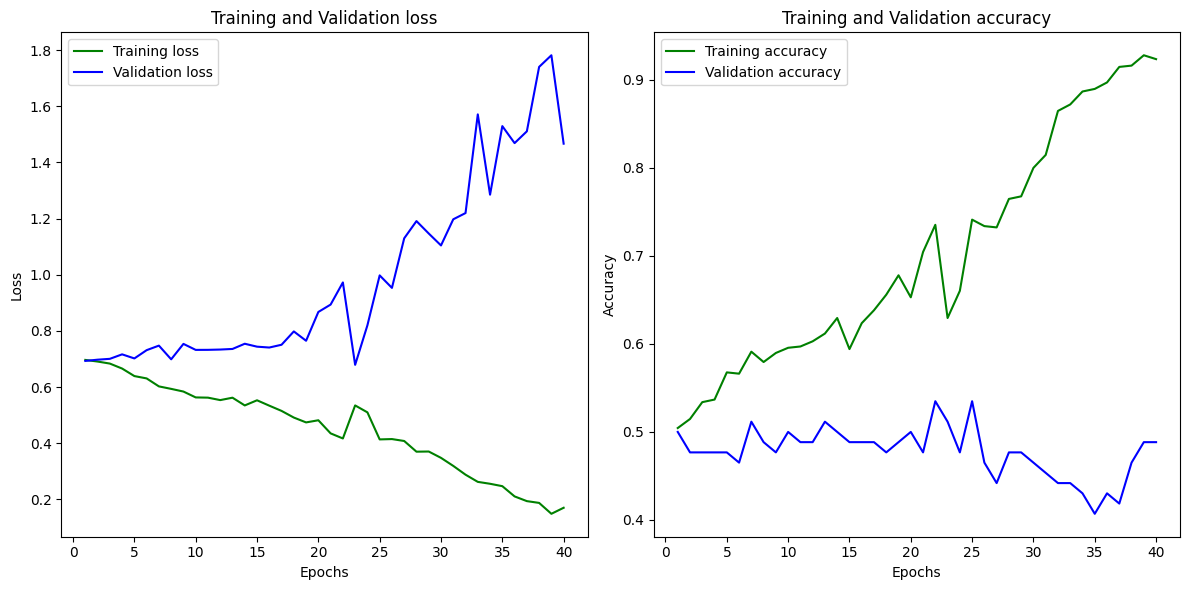

In [191]:
train(nli_model, num_epochs, criterion, optimizer)

In [50]:
OUT_OF_VOCAB = '<OOV>'
PAD_TAG = '<PAD>'
START_TAG = '<BOS>'
END_TAG = '<EOS>'


class NLIDataset_non_ELMo(Dataset):
    def __init__(self, hypotheses, premises, labels, max_sentence_length, word_vocab: WordLevelVocab):
        self.hypotheses = hypotheses
        self.premises = premises
        self.labels = labels
        self.max_sentence_length = max_sentence_length
        self.word_vocab = word_vocab

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # convert the sentences to indices
        hypothesis = [self.word_vocab.word_to_index(word) for word in self.hypotheses[idx]]
        premise = [self.word_vocab.word_to_index(word) for word in self.premises[idx]]
        label = self.labels[idx]

        return torch.tensor(hypothesis), torch.tensor(premise), torch.tensor(label)

        # return torch.tensor(self.hypotheses[idx]), torch.tensor(self.premises[idx]), torch.tensor(self.labels[idx])

    def format(self, batch):
        hypotheses, premises, labels = zip(*batch)

        bos_token = word_vocab.word_to_index(START_TAG)
        eos_token = word_vocab.word_to_index(END_TAG)
        pad_token = word_vocab.word_to_index(PAD_TAG)

        hypotheses = [[bos_token] + list(hypothesis) + [eos_token] for hypothesis in hypotheses]
        premises = [[bos_token] + list(premise) + [eos_token] for premise in premises]

        hypotheses = [sentence[:self.max_sentence_length] + [pad_token] * (self.max_sentence_length - len(sentence)) for sentence in hypotheses]
        premises = [sentence[:self.max_sentence_length] + [pad_token] * (self.max_sentence_length - len(sentence)) for sentence in premises]

        for i in range(len(hypotheses)):
            hypotheses[i] = torch.tensor(hypotheses[i], dtype=torch.long)
            premises[i] = torch.tensor(premises[i], dtype=torch.long)

        hypotheses = torch.stack(hypotheses)
        premises = torch.stack(premises)

        labels = torch.tensor(labels, dtype=torch.long)
        return hypotheses, premises, labels

In [39]:
# train_hypotheses_copy

In [40]:
train_hypotheses_non_elmo = train_hypotheses_copy
train_premises_non_elmo = train_premises_copy

val_hypotheses_non_elmo = val_hypotheses_copy
val_premises_non_elmo = val_premises_copy

test_hypotheses_non_elmo = test_hypotheses_copy
test_premises_non_elmo = test_premises_copy

In [41]:
nli_train_dataset_non_elmo = NLIDataset_non_ELMo(train_hypotheses_non_elmo, train_premises_non_elmo, train_labels, 15, word_vocab)
train_dataloader_non_elmo = DataLoader(nli_train_dataset_non_elmo, batch_size=32, shuffle=True, collate_fn=nli_train_dataset_non_elmo.format)

In [42]:
nli_train_dataset_non_elmo[0]

/tmp/ipykernel_8712/3737501049.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(hypothesis), torch.tensor(premise), torch.tensor(label)


(tensor([ 4258, 43327,  5026,     0,    89, 22133,     0,  6517, 65545, 15429,
         18608,    89, 24621,     0,  2755, 22133,     0,  9146, 65545,   630,
             0,   630,  2755,     0,  2755, 94669,  8773, 28065,  4258, 14450,
             0,  6793, 14450, 16749, 13669, 14450,     0,     0,  9146, 22133,
          2755, 65545,    89,     0, 15429,  7182,     0, 22247,     0, 22247,
             0,  9592, 15429, 18608,     0, 19051, 18608,     0,     0,  9911,
          4258,  9146, 65545,   630,     0,  6677,  4258, 22133,     0,  9911,
          4258,  2755, 22133,     0,  4909, 11638, 18608, 15429,     0,  6793,
         26340, 17038, 18608,     0,  7182, 24621,    89, 18608,     0,  6517,
         26340, 17038, 18608,     5]),
 tensor([ 9146, 65545, 15429, 24621,    89, 22133,  9146,     0,  2755, 14450,
             0, 15429, 24621, 11638,    89, 18608,     0,  9911,  4258, 22133,
             0, 11638, 65545, 15429, 24621, 13195, 28065,  8773, 22133,     0,
          651

In [43]:
for batch in train_dataloader_non_elmo:
    print(batch)
    break

(tensor([[    2, 13195, 28065,  8773, 22133, 26340,     0, 22247, 14450,    57,
         14450,     0,  1176, 22133,  6793],
        [    2,  5026,     0, 26340,     0, 15252,  8773,     0, 26340, 24621,
          8773, 18608,     0,    89, 22133],
        [    2,  2755, 94669,  9241,     0,  9146, 16749,  4909, 14450,     0,
          4909, 18608,  7642, 13669, 14450],
        [    2, 13195, 28065,  8773, 22133, 26340,     0, 26340, 65545, 24940,
            57,     0, 24940,  8773,     0],
        [    2, 26340, 43327,    89,     0,    89, 22133,     0,  6517, 65545,
          9241,  9146, 14450,     0,  4258],
        [    2,   630, 26340,  5026,     0, 15429,  7182, 18608, 16749,     0,
          2755, 18608,  5026,     0,    89],
        [    2, 11638,  8773,     0,  8773,  7642,  5026, 16749,  1176, 24621,
         16749,     0,  2755, 24621,     0],
        [    2,  5026,     0, 26340,     0, 15252,  8773,     0, 26340, 24621,
          8773, 18608,     0,    89, 22133],
       

/tmp/ipykernel_8712/3737501049.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(hypothesis), torch.tensor(premise), torch.tensor(label)


In [44]:
class NLIModel_non_ELMo(nn.Module):
    def __init__(self, embedding_dim, hidden_dim_1, hidden_dim_2, num_classes, device):
        super(NLIModel_non_ELMo, self).__init__()
        self.embedding = nn.Embedding(word_vocab.num_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim_1, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim_1 * 2, num_classes)  # Multiply by 2 because we will concatenate the representations of s1 and s2
        self.non_linearity = nn.ReLU()

    def forward(self, s1, s2):
        s1 = self.embedding(s1)
        s2 = self.embedding(s2)

        print(s1.shape, s2.shape)

        output_s1, _ = self.lstm(s1)
        output_s2, _ = self.lstm(s2)

        # Use the final hidden state as the representation of each sequence
        rep_s1 = output_s1[:, -1, :]
        rep_s2 = output_s2[:, -1, :]

        # Concatenate the representations of s1 and s2
        rep = torch.cat((rep_s1, rep_s2), dim=1)

        output = self.fc(rep)
        output = self.non_linearity(output)

        return output

In [48]:
non_elmo_train_dataset = NLIDataset_non_ELMo(train_hypotheses_non_elmo, train_premises_non_elmo, train_labels, 15, word_vocab)

In [45]:
nli_model_non_elmo = NLIModel_non_ELMo(300, 150, 75, 2, device).to(device)
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nli_model_non_elmo.parameters(), lr=0.0001)

In [49]:
def train(model, num_epochs, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total = 0
        correct = 0

        for s1, s2, scores in tqdm(train_dataloader_non_elmo):
            s1 = s1
            s2 = s2
            scores = scores.to(device)
            optimizer.zero_grad()
            s1 = torch.stack(s1, dim=1).to(device)
            s2 = torch.stack(s2, dim=1).to(device)
            output = model(s1, s2)
            output = output[:,-1,:]
            pred = torch.argmax(output, dim=1)
            correct += (pred == scores).sum().item()
            total += scores.size(0)
            loss = criterion(output, scores)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

In [192]:
# train(nli_model_non_elmo, num_epochs, criterion, optimizer)

In [ ]:
# for batch in train_dataloader:
#     print(batch)
#     break

In [ ]:
# # tokenize the data
# train_hypotheses = [tokenize(h) for h in train_hypotheses]
# train_premises = [tokenize(p) for p in train_premises]

# val_hypotheses = [tokenize(h) for h in val_hypotheses]
# val_premises = [tokenize(p) for p in val_premises]

# test_hypotheses = [tokenize(h) for h in test_hypotheses]
# test_premises = [tokenize(p) for p in test_premises]

In [ ]:
# train_premises

In [ ]:
# OUT_OF_VOCAB = '<OOV>'
# PAD_TAG = '<PAD>'
# START_TAG = '<BOS>'
# END_TAG = '<EOS>'

# class NLIDataset(Dataset):
#     def __init__(self, hypotheses, premises, labels, word_vocab: WordLevelVocab, char_vocab: CharLevelVocab, max_word_length: int = 15, max_sequence_length: int = 15):
#         self.hypotheses = hypotheses
#         self.premises = premises
#         self.labels = labels
#         self.word_vocab = word_vocab
#         self.char_vocab = char_vocab
#         # self.labels_to_idx = labels_to_idx
#         self.max_word_length = max_word_length
#         self.max_sequence_length = max_sequence_length

#     def __len__(self):
#         return len(self.hypotheses)
    
#     def __getitem__(self, idx):
#         hypothesis = self.hypotheses[idx]
#         premise = self.premises[idx]
#         label = self.labels[idx]

#         return [torch.tensor([self.char_vocab.char_to_index(char) for char in word], dtype=torch.long) for word in hypothesis], [torch.tensor([self.char_vocab.char_to_index(char) for char in word], dtype=torch.long) for word in premise], torch.tensor(label, dtype=torch.long)

#     def collate_fn(self, batch):
#         hypotheses, premises, labels = zip(*batch)

#         bos_token = []
#         for c in START_TAG:
#             bos_token.append(self.char_vocab.char_to_index(c))
#         bos_token = torch.tensor(bos_token, dtype=torch.long)

#         eos_token = []
#         for c in END_TAG:
#             eos_token.append(self.char_vocab.char_to_index(c))
#         eos_token = torch.tensor(eos_token, dtype=torch.long)

#         pad_token = []
#         for c in PAD_TAG:
#             pad_token.append(self.char_vocab.char_to_index(c))
#         pad_token = torch.tensor(pad_token, dtype=torch.long)

#         hypotheses = [[bos_token] + h + [eos_token] for h in hypotheses]
#         premises = [[bos_token] + p + [eos_token] for p in premises]

#         hypotheses = [h[:self.max_sequence_length] + [pad_token] * (self.max_sequence_length - len(h)) for h in hypotheses]
#         premises = [p[:self.max_sequence_length] + [pad_token] * (self.max_sequence_length - len(p)) for p in premises]

#         for i in range(len(hypotheses)):
#             for j in range(len(hypotheses[i])):
#                 # print(type(hypotheses[i][j][:self.max_word_length]),type([pad_token]), type([pad_token] * (self.max_word_length - len(hypotheses[i][j]))))
#                 hypotheses[i][j] = torch.cat([hypotheses[i][j][:self.max_word_length], pad_token * (self.max_word_length - len(hypotheses[i][j]))])
#             for j in range(len(premises[i])):
#                 premises[i][j] = torch.cat([premises[i][j][:self.max_word_length], pad_token * (self.max_word_length - len(premises[i][j]))])

#         hypotheses = torch.stack([torch.stack(h) for h in hypotheses])
#         premises = torch.stack([torch.stack(p) for p in premises])
        
#         labels = torch.tensor(labels, dtype=torch.long)

#         # concat hypothesis + EOS + premise and return that along with label
#         sequence = torch.cat([hypotheses, [END_TAG] * (len(hypotheses))], dim=1)
#         sequence = torch.cat([sequence, premises], dim=1)

#         return sequence, labels

In [ ]:
# nli_train_dataset = NLIDataset(train_hypotheses, train_premises, train_labels, word_vocab, char_vocab)
# nli_val_dataset = NLIDataset(val_hypotheses, val_premises, val_labels, word_vocab, char_vocab)
# nli_test_dataset = NLIDataset(test_hypotheses, test_premises, test_labels, word_vocab, char_vocab)

In [ ]:
# nli_train_dataset[2]

In [ ]:
# ner_train_dataloader = DataLoader(nli_train_dataset, batch_size=32, shuffle=True, collate_fn=nli_train_dataset.collate_fn)
# ner_val_dataloader = DataLoader(nli_val_dataset, batch_size=32, shuffle=False, collate_fn=nli_val_dataset.collate_fn)
# ner_test_dataloader = DataLoader(nli_test_dataset, batch_size=32, shuffle=False, collate_fn=nli_test_dataset.collate_fn)